<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp02_Epoch_params_t_SNE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum 
* Add 
    * train, test loss plot
    * save model's state dict

* ✅ Check Point
    * Just try it again...!
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

In [2]:
! nvidia-smi

Thu Jul  2 07:25:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [37]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [7]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])
# trainset = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/Malimg_Exp_200611/malimg",
#                                             transforms = transform)
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [12]:
# print train_label
trainset[0][1]

0

In [13]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [14]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [25]:
# train_dataset[0][0]
# train_dataset[0][0].shape

torch.Size([1, 224, 224])

In [19]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

In [20]:
# for idx, (data, _) in enumerate(train_loader):
#     print(data[3], data[4], data.type(), data.shape)
#     print(_, _.type())
#     print("==" * 20 )

In [21]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [22]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([11, 13, 10,  3, 10,  0, 24,  2, 17,  2,  2,  2, 12, 22,  2,  2])


In [40]:
for batch_idx, (data, _) in enumerate(train_loader):
    print(data.shape, _.shape)
    if batch_idx == 5:
        break

torch.Size([16, 1, 224, 224]) torch.Size([16])
torch.Size([16, 1, 224, 224]) torch.Size([16])
torch.Size([16, 1, 224, 224]) torch.Size([16])
torch.Size([16, 1, 224, 224]) torch.Size([16])
torch.Size([16, 1, 224, 224]) torch.Size([16])
torch.Size([16, 1, 224, 224]) torch.Size([16])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Instantaccess Lolyda.AA2 Fakerean Allaple.L Fakerean Adialer.C Yuner.A Allaple.A Obfuscator.AD Allaple.A Allaple.A Allaple.A Lolyda.AA1 VB.AT Allaple.A Allaple.A 


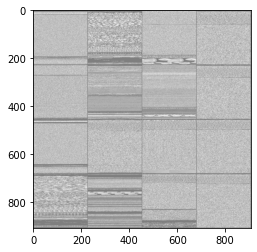

In [23]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [41]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [42]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [43]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [44]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'

In [61]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

colors = []
def train(epoch):
    model.train()
    train_loss = 0
    latent_vector = np.zeros(())
    latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = model(data)
        # z vector는 torch type

        latent_vector = z.detach().cpu().clone().numpy()
        # plot t-SNE per Epoch
        # extract 100 feature to 2
        # save batch_labe;'s for plotting
        # dataiter = iter(train_loader)
        # images, labels = dataiter.next()

        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
    if epoch % 10 == 0:  # 10의 배수 단위로 parameter 저장(State_dict)
        torch.save(model.state_dict(), ('/Again_Exp02_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장
    
    # Epoch 단위 t-SNE plot 저장
    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector.detach().cpu().clone().numpy())
    print(Z_embedded.shape)  # expect (16, 2)
    # https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    plt.figure(figsize=(16,10))
    plt.xlim(Z_embedded[:, 0].min(), Z_embedded[:,0].max() + 1)
    plt.ylim(Z_embedded[:, 1].min(), Z_embedded[:,1].max() + 1)
    
    for i in range(len(Z_embedded[0])):
        plt.text(Z_embedded[i, 0], Z_embedded[i, 1], str(batch_idx),
                # color = colors[label[i]],
                fontdict={'weight':'bold', 'size':9})
    plt.xlabel("t-SNE feature 0")
    plt.ylabel("t-SNE feature 1")
    plt.savefig('./' + str(epoch) + '_t_SNE.png', dpi=300)

# save latent vector per every step
    with open((str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
        np.save(f, latent_vector)


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(16, 1, 224, 224)[:n]])
                save_image(comparison.cpu(),
                         './results_02/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))



1
(16, 2)
Train Epoch: 1 [0/7471 (0%)]	Loss: 35143.496094
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
Train Epoch: 1 [160/7471 (2%)]	Loss: 39750.980469
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)
(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train Epoch: 1 [320/7471 (4%)]	Loss: 37252.589844
(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train Epoch: 1 [480/7471 (6%)]	Loss: 36309.476562
(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(16, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SystemError: ignored

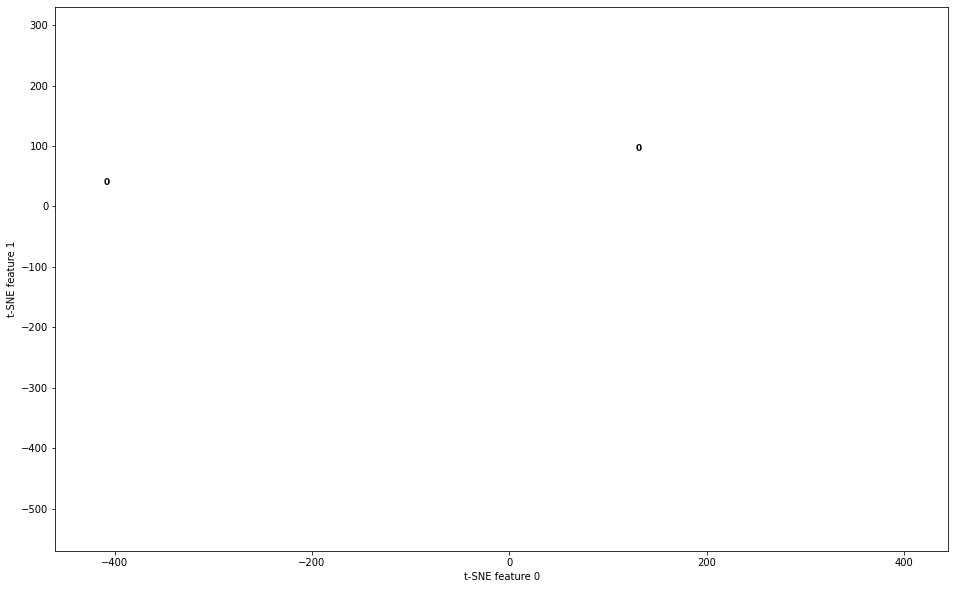

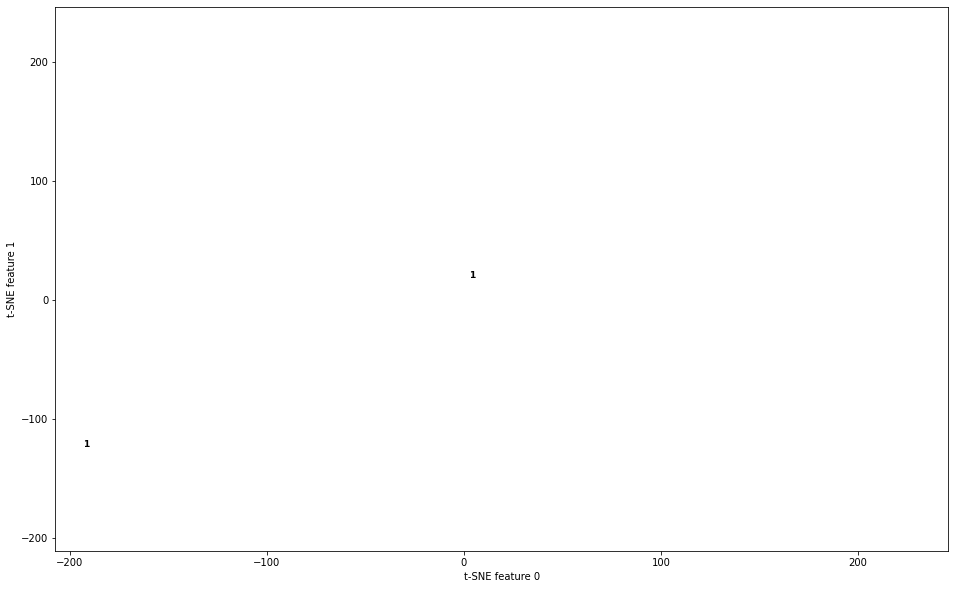

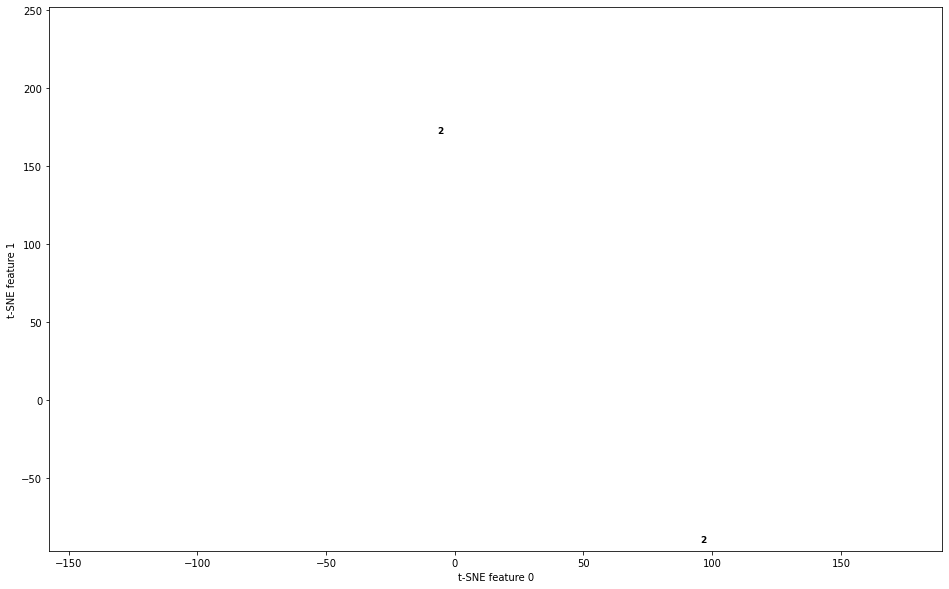

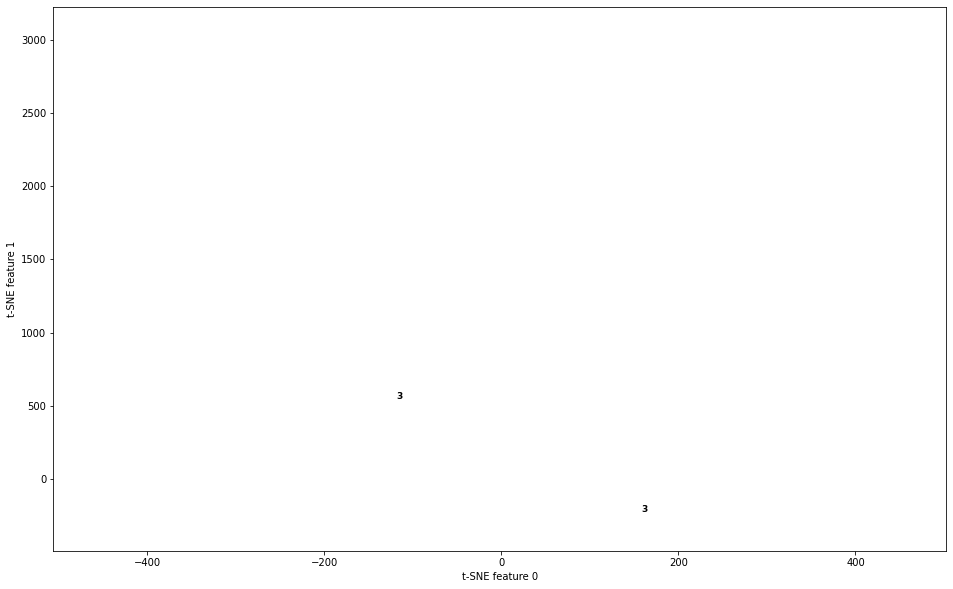

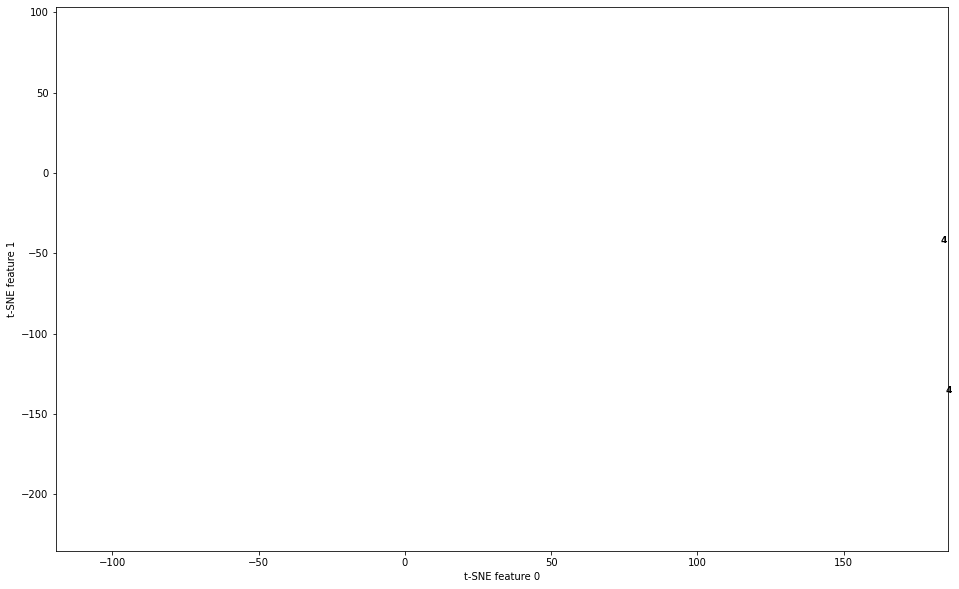

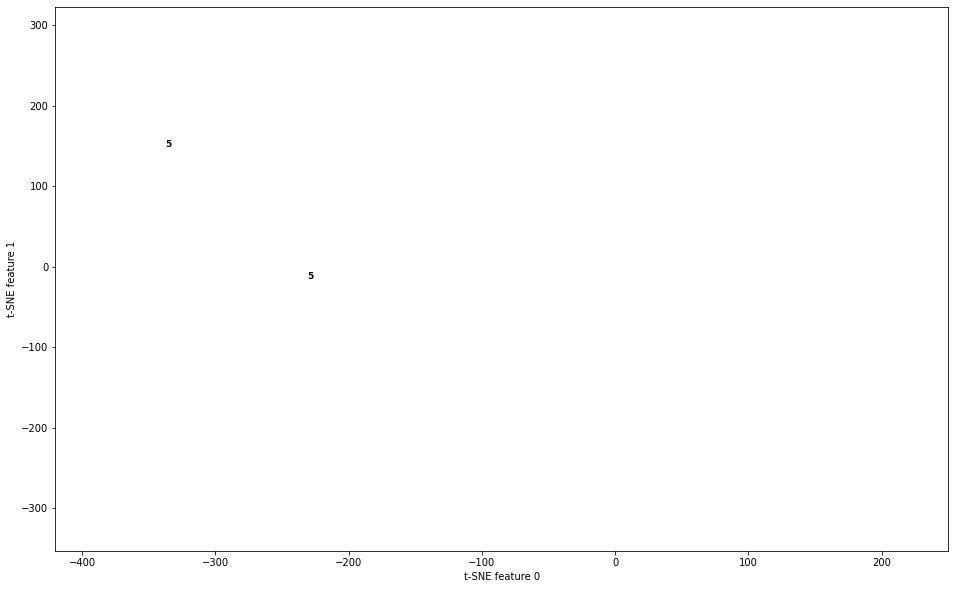

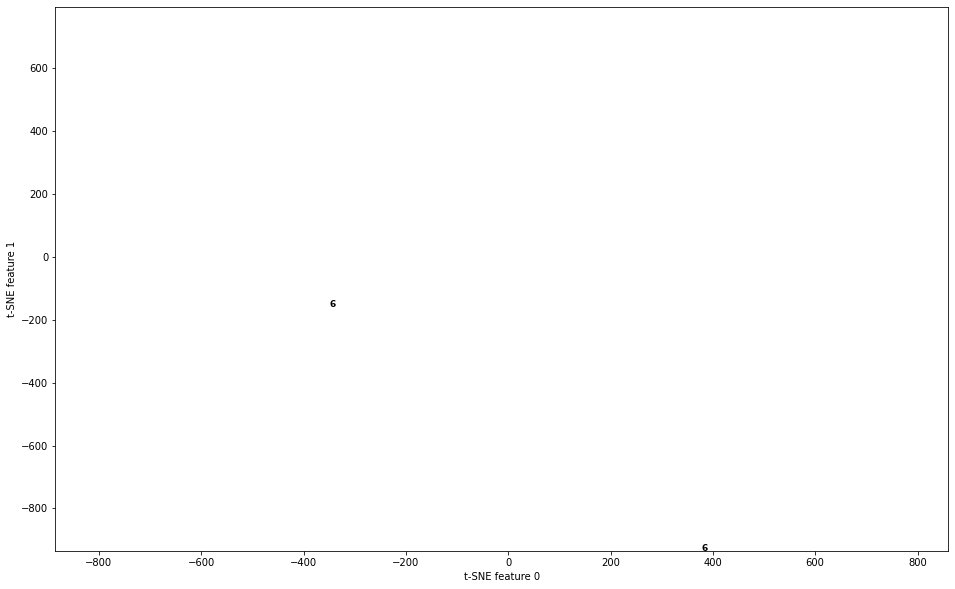

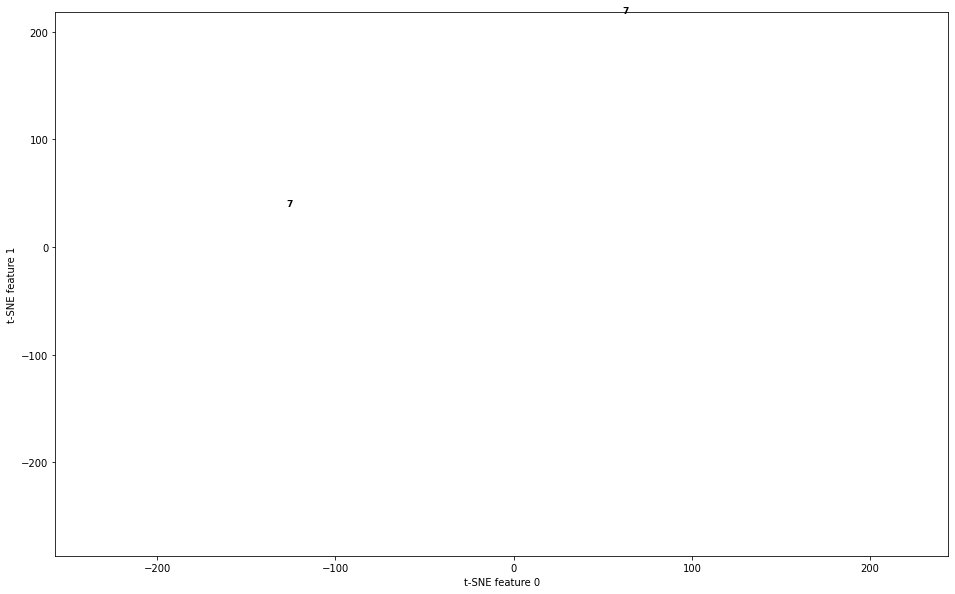

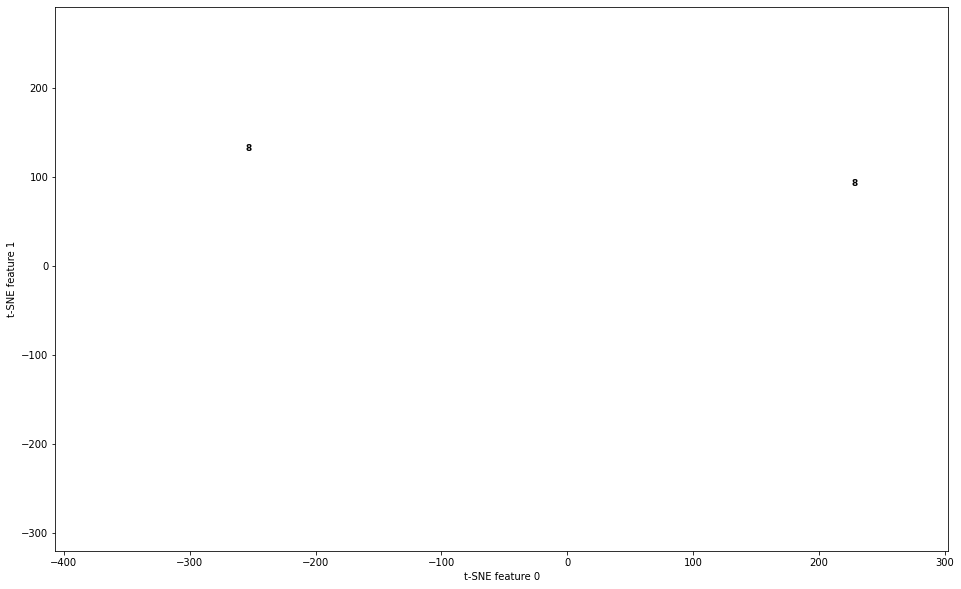

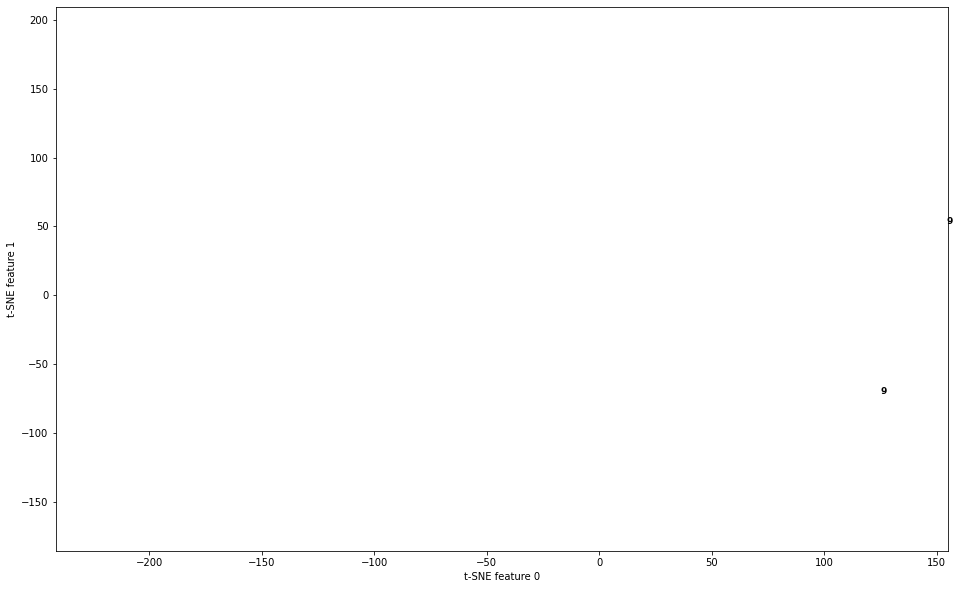

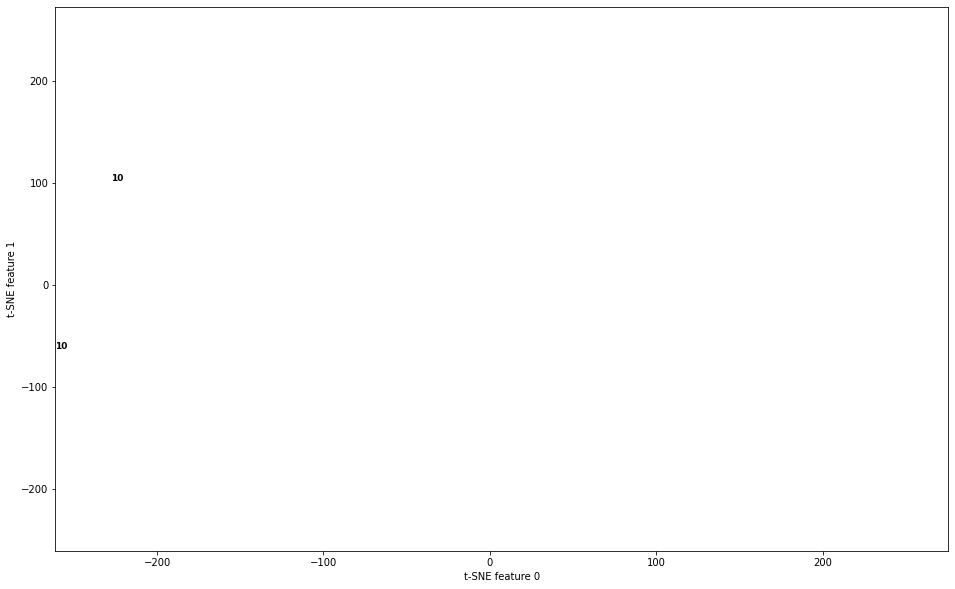

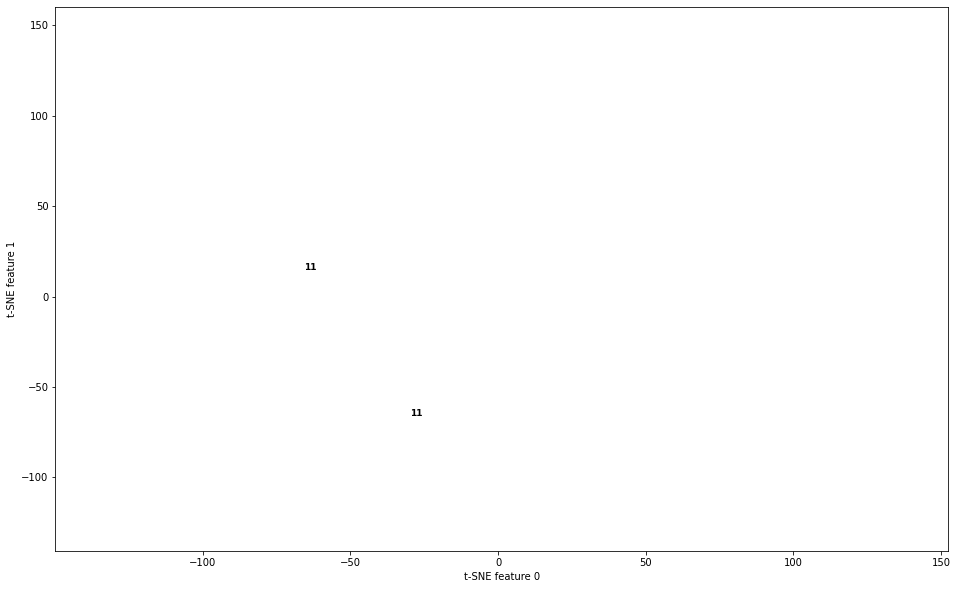

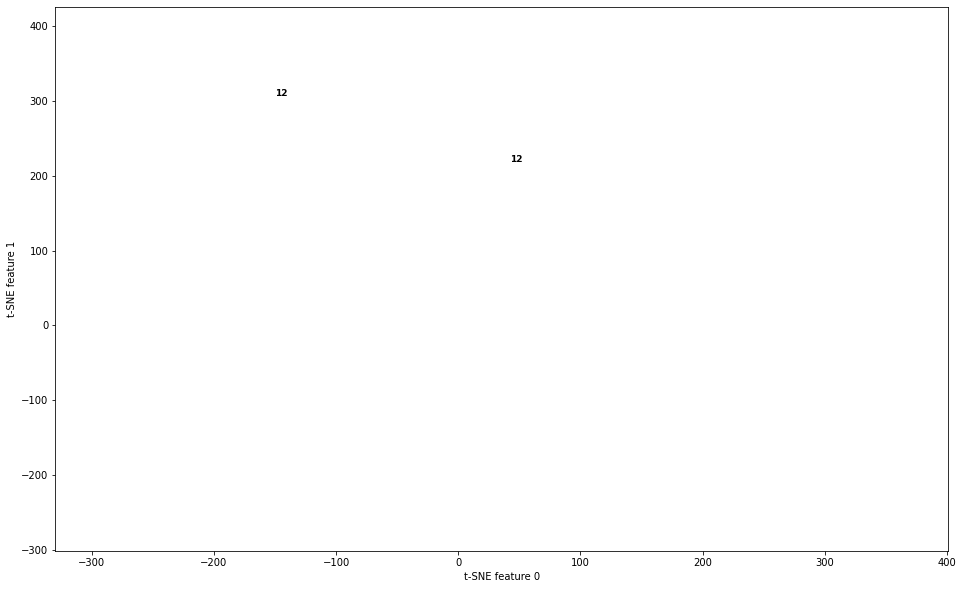

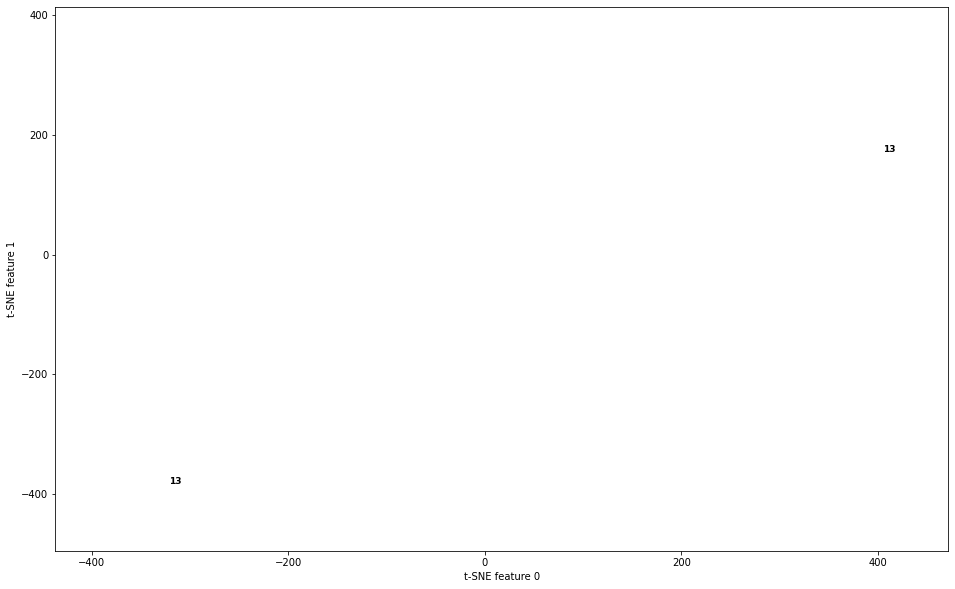

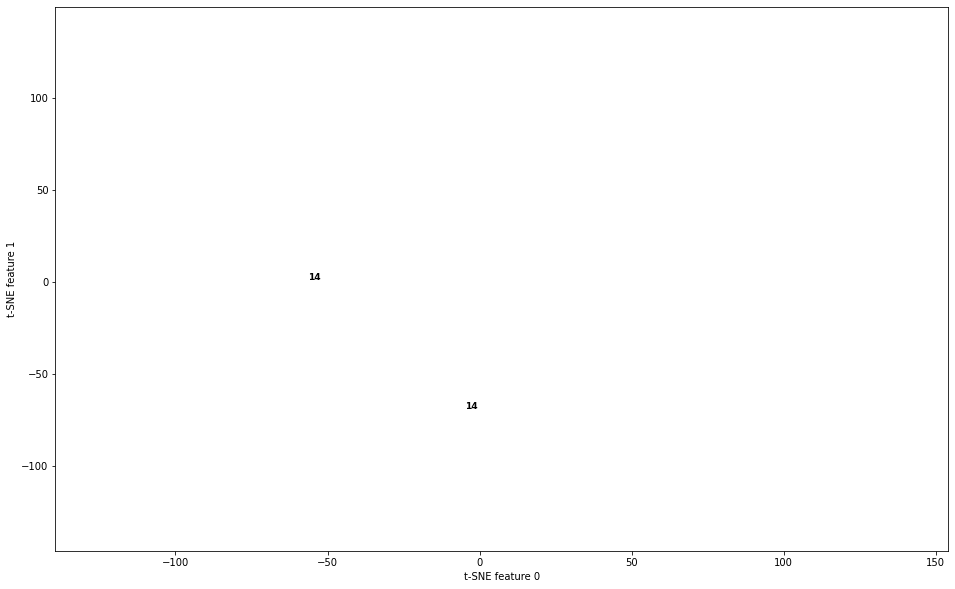

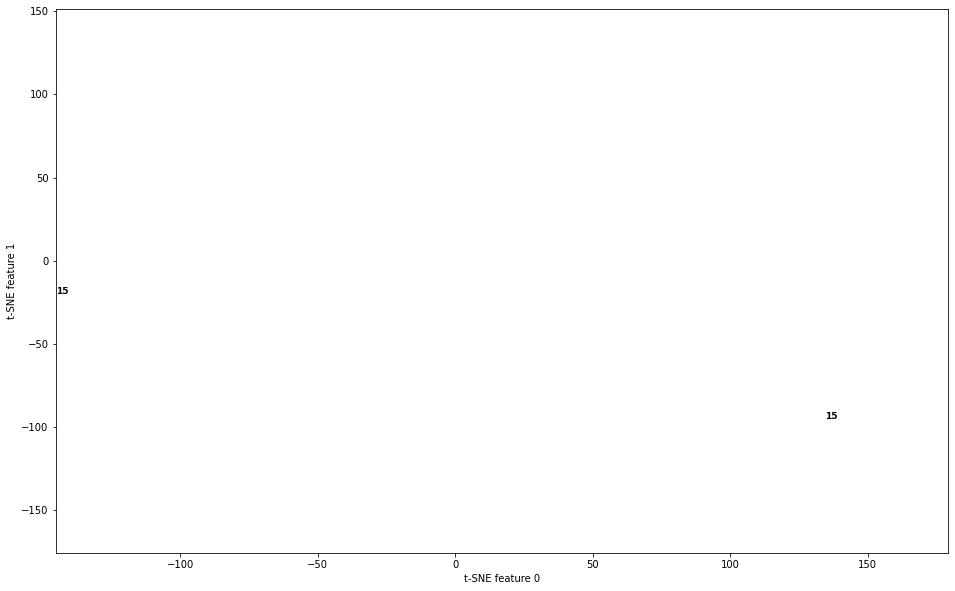

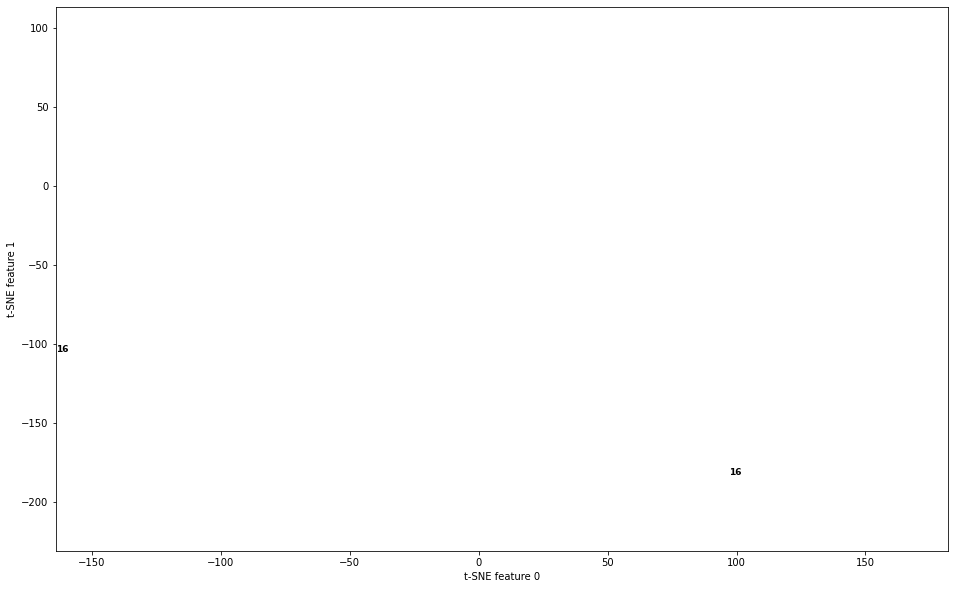

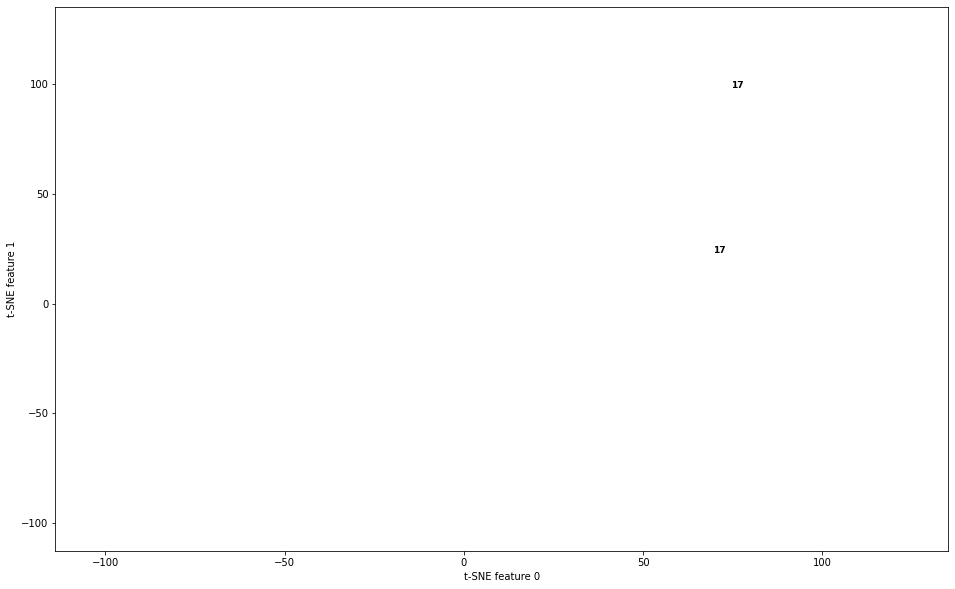

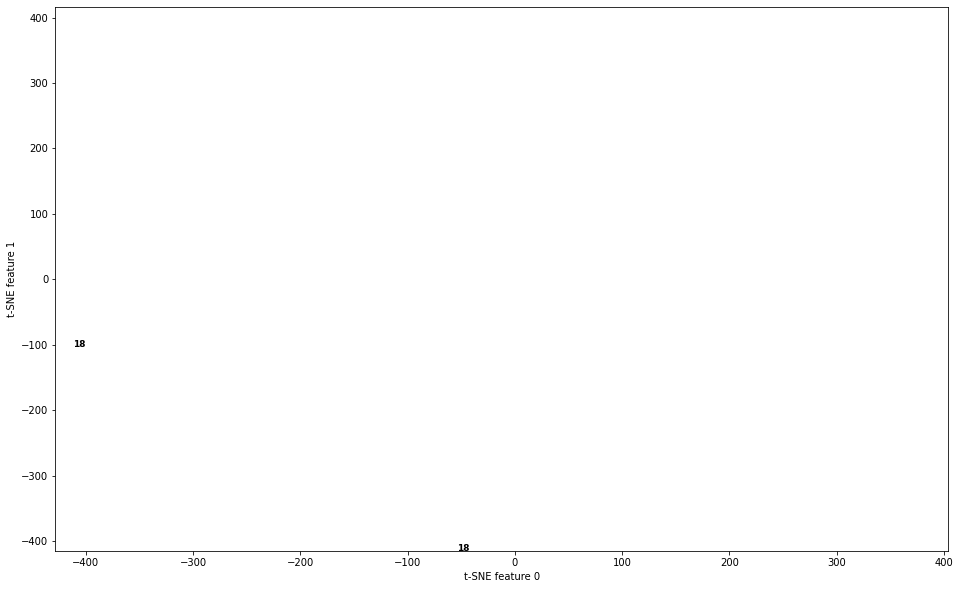

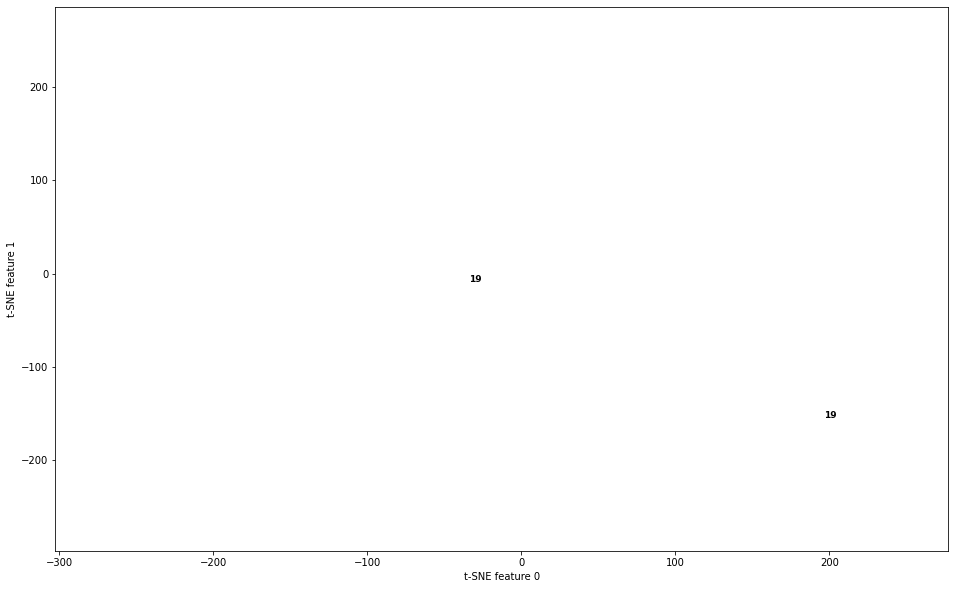

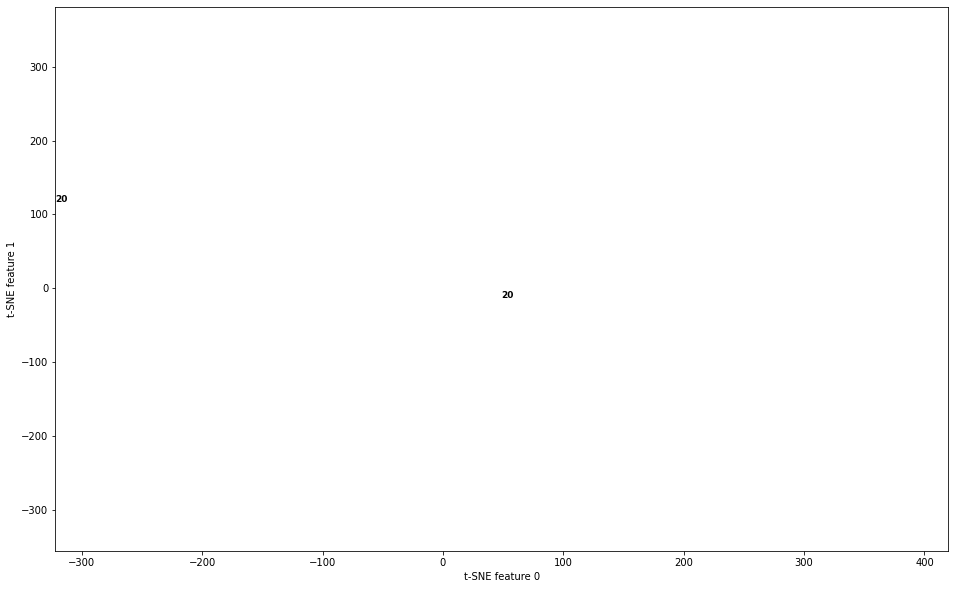

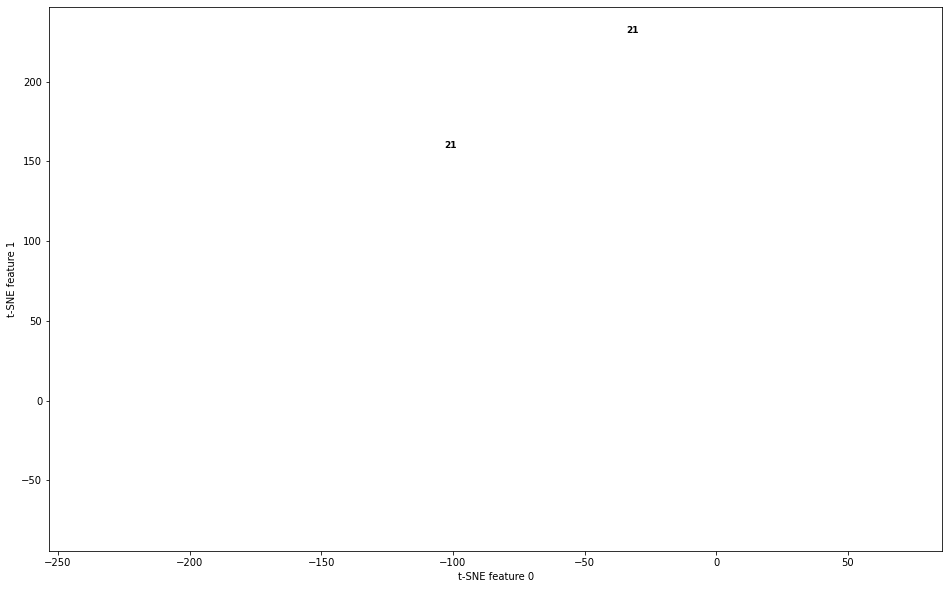

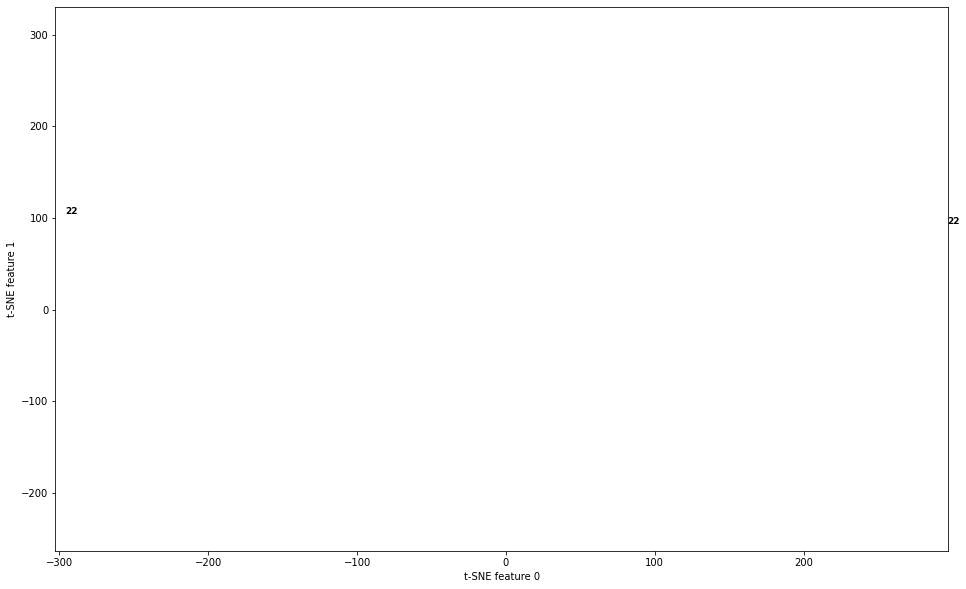

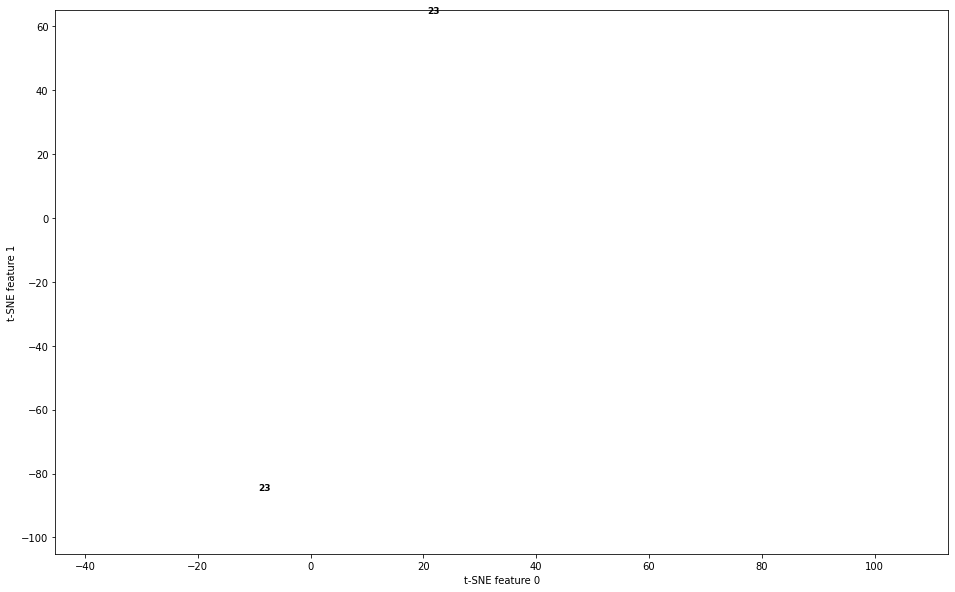

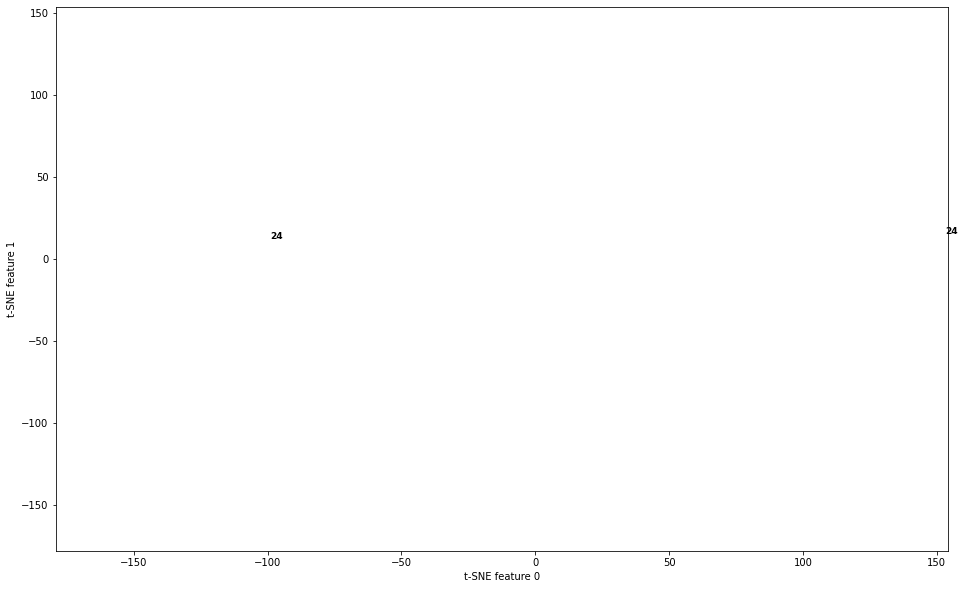

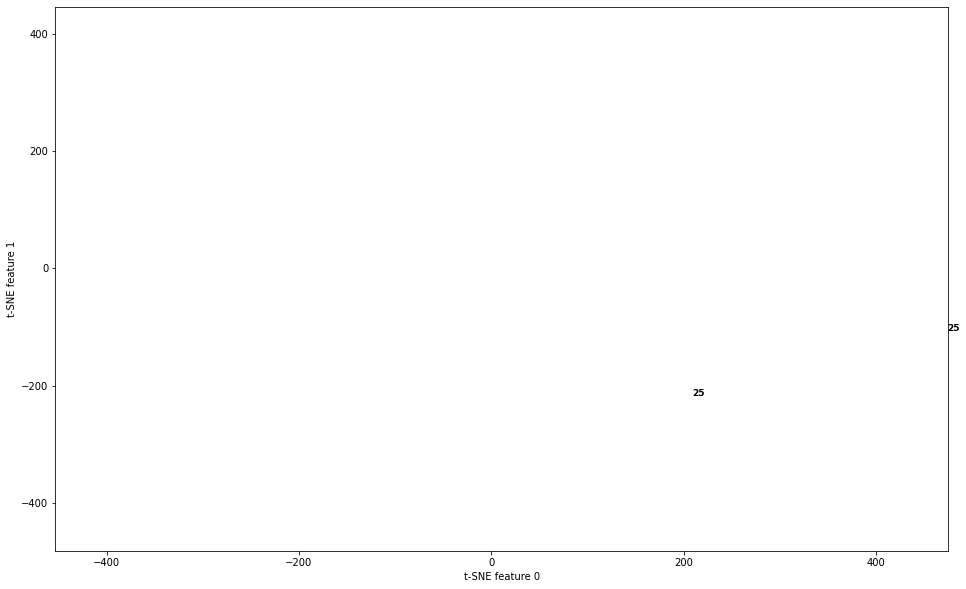

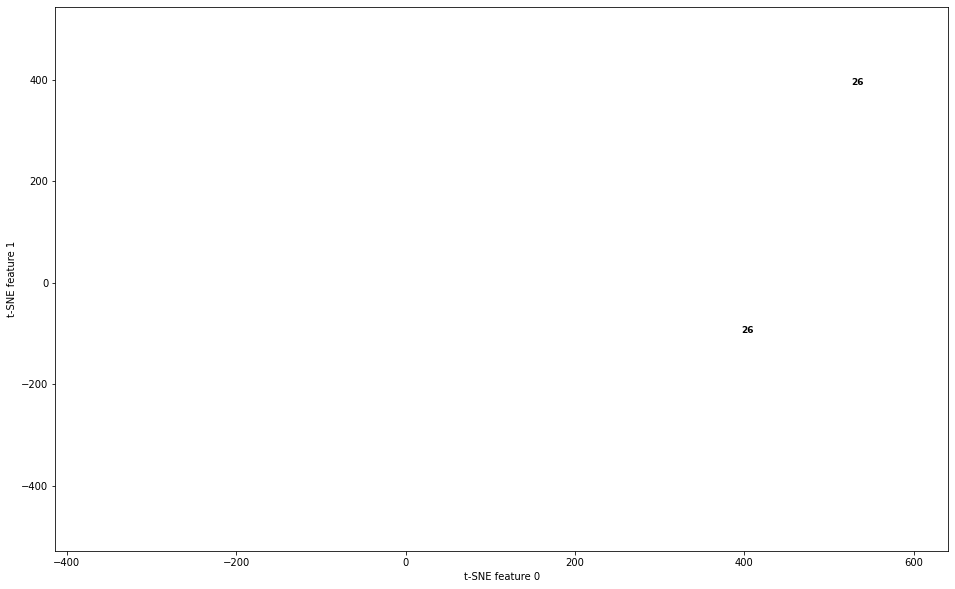

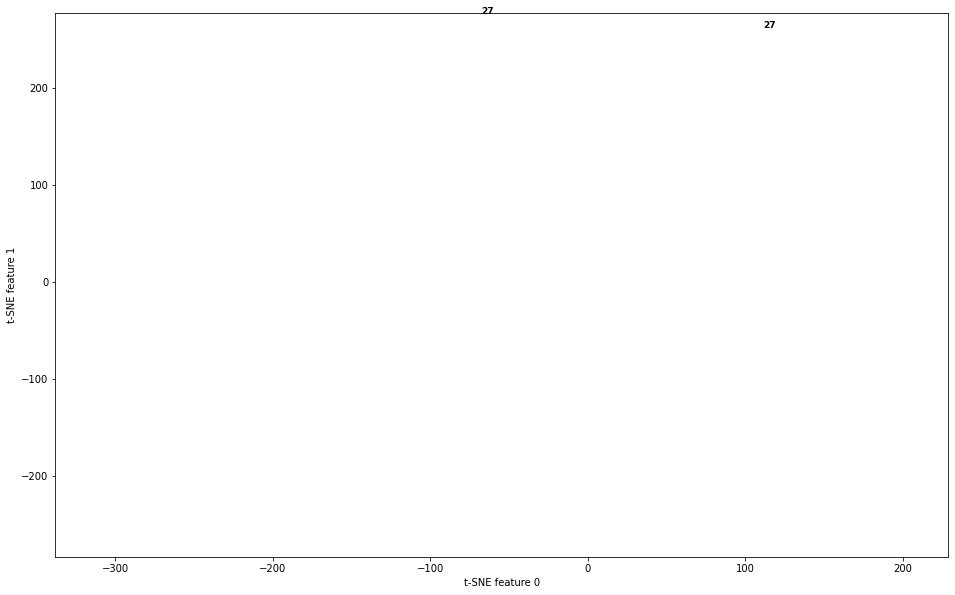

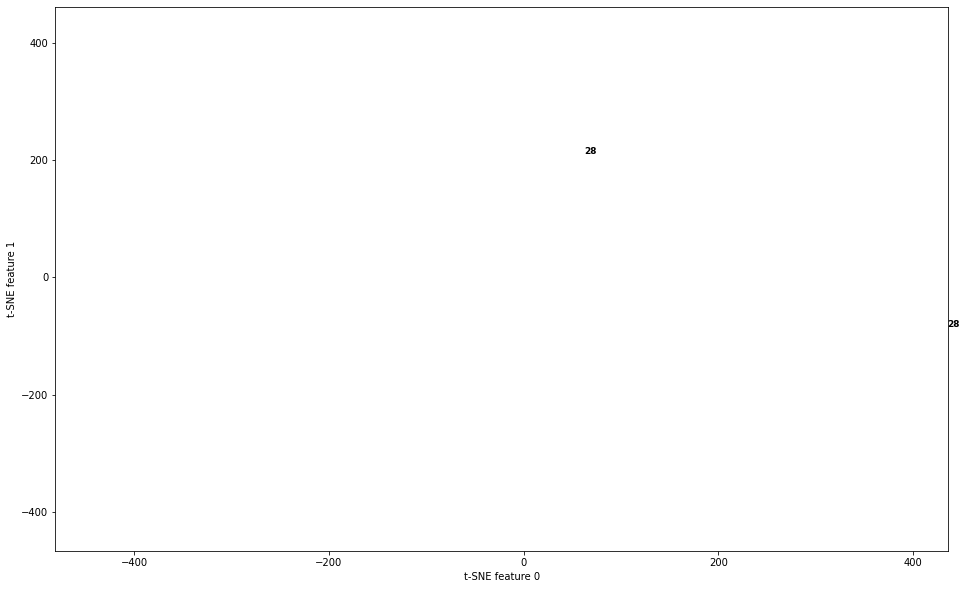

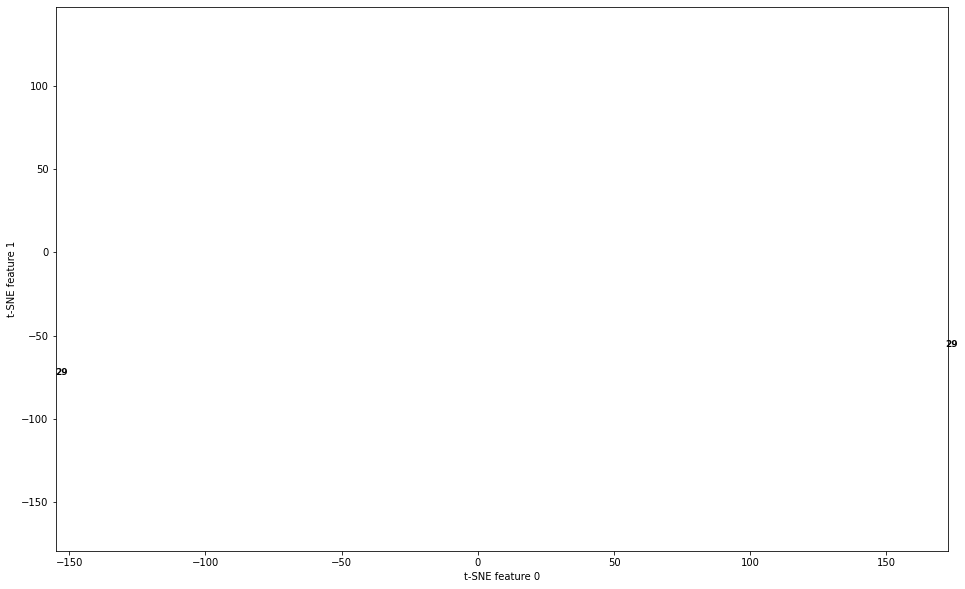

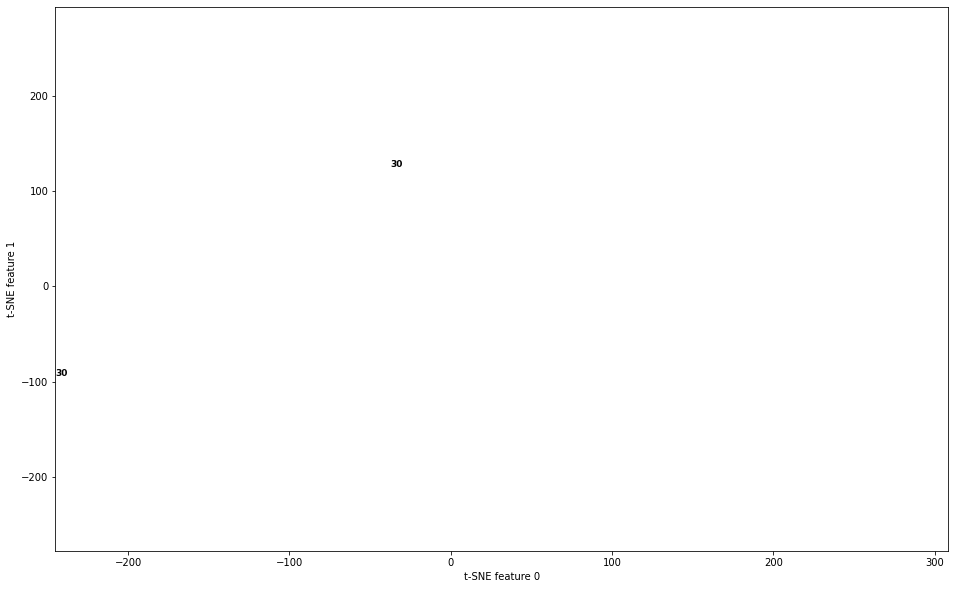

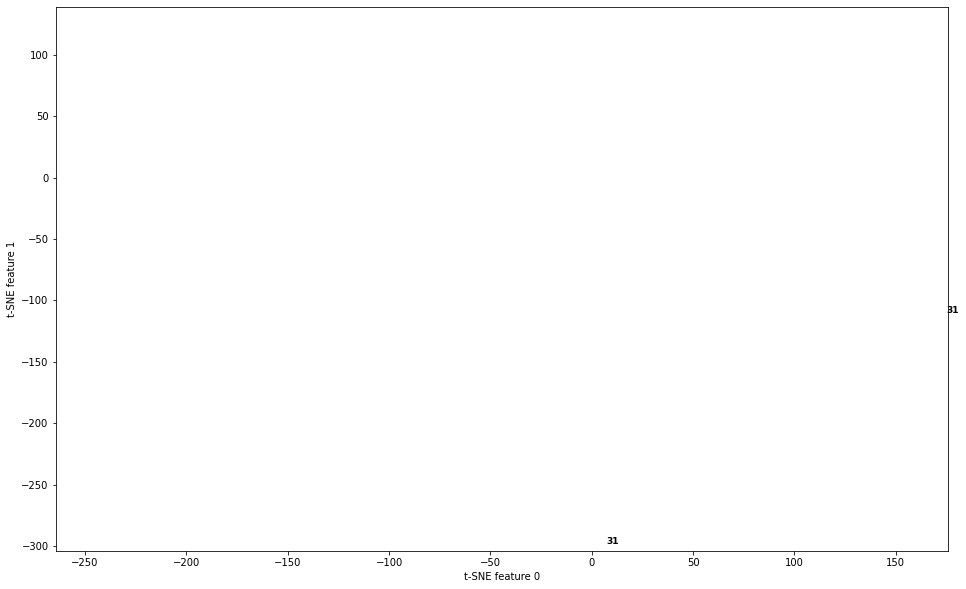

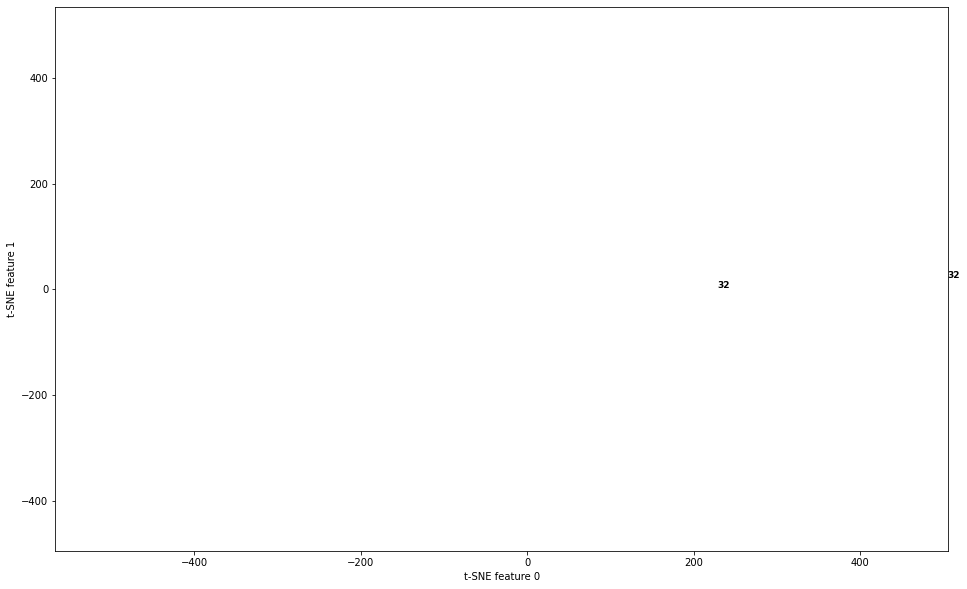

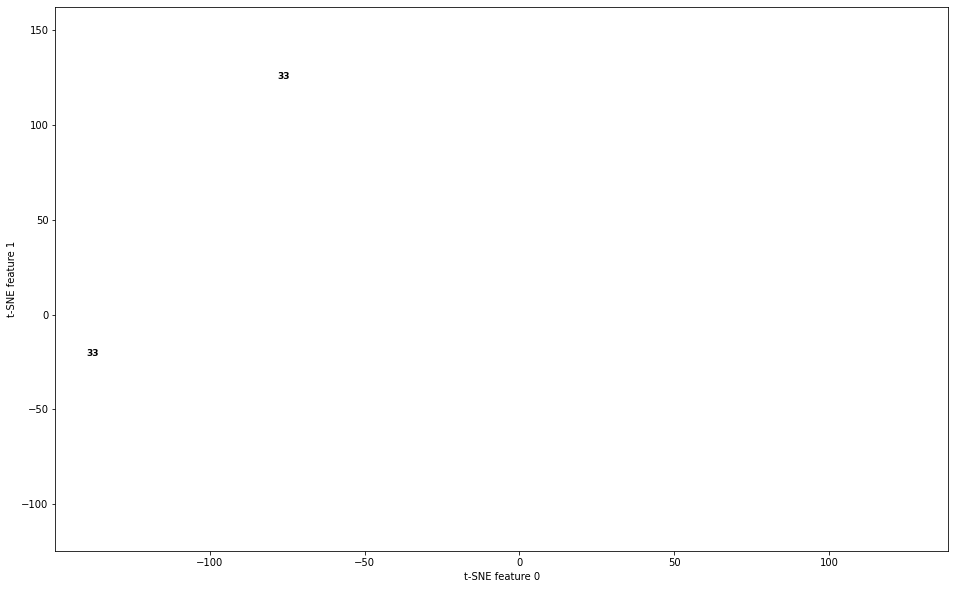

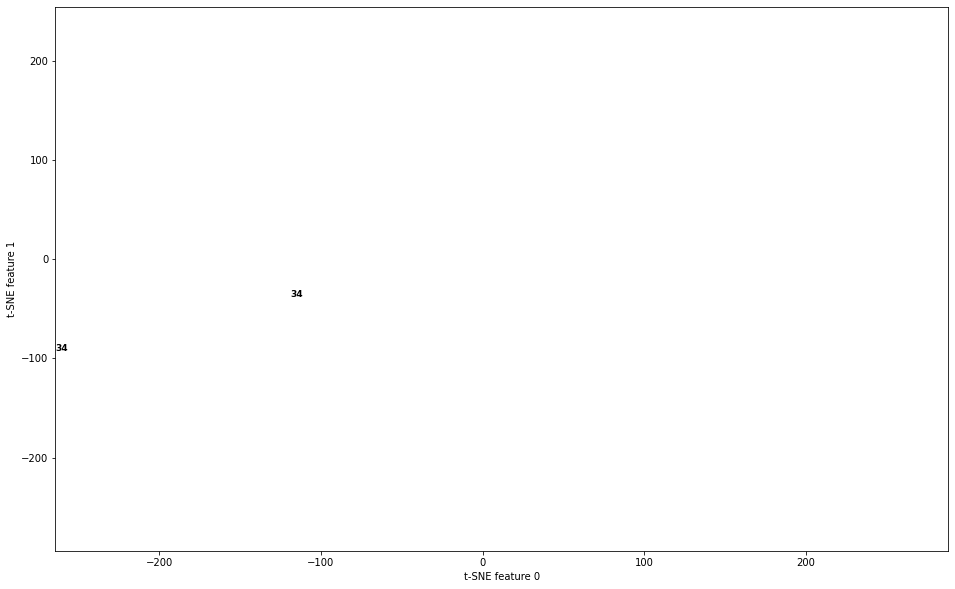

In [62]:
epochs = 1

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_02/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './results_02/sample_' + str(epoch) + '.png')